Q1) Prelimanary overview =  the two datasets contain involve analysis and effect of various objective which are treated as features/variables for modelling purposes on the quality of wine for two different classes of wine. The last column contains the assigned quality to the given wine sample based on various features which we can treat as target values for regression problem. Exact quantification can be found in attached documentaion which validates its use for scienctific purposes especially regression and feature selection

1 b) Explore = invloves identifying feautures , target values , whether their are any null points or not, identify outliers

Visulaise = maybe print few rows (chat gpt recommendation), quantify no. of null points, outliers
print some basic statistcs like mean median mode

Preprocessing = fill null points using strategies like imputation(gpt), removing outliers
chat gpt := which may include feature scaling, normalization, or encoding categorical variables.

In [55]:
import pandas as pd
import types
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.feature_selection import RFECV
import time
import matplotlib.pyplot as plt

In [53]:
##explore and visualize

# Load the dataset
wine_red = pd.read_csv("winequality-red.csv", sep=';')
wine_white = pd.read_csv("winequality-white.csv", sep=';')

##deeisplay various parameters asosciated with data
##convection input matrix = N x D

##no. of rows = no of samples
N_red = wine_red.shape[0] ##axis 0
N_white = wine_white.shape[0] ##axis 0
##no of features= no of columns - 1(target column)
D_red = wine_red.shape[1] - 1 ##axis 1
D_white = wine_white.shape[1] - 1 ##axis 1 

##seperate features and target
featuresRed = wine_red.drop('quality', axis=1)##quality = target selectds all columns expect quality
targetRed = wine_red['quality']
featuresWhite = wine_white.drop('quality', axis=1)
targetWhite = wine_white['quality']

##desriptive stats assosciated with data ref : https://www.w3schools.com/python/pandas/ref_df_describe.asp 
Des_Red = wine_red.describe() ##obj connecting description (mean , median mode, max etc of data)
Des_white = wine_white.describe()

##null points
##ref chat gpt ,is_null converts every datapoint to bool (Non empty => 0 empty => non zero)
NullCountRed = wine_red.isnull().sum() ##sum all non zero gives null count in every column
NullCountWhite = wine_white.isnull().sum()

##outliers bas
##ref : chatgpt IQR method basically calculate data range within which 50% of middle data points
def count_outliers(df, columnName):
    Q1 = df[columnName].quantile(0.25) # first quartile of data
    Q3 = df[columnName].quantile(0.75)# rnd quartile 
    IQR = Q3 - Q1  #3 range we are assuming to contain data (excluding outliers)
    lower_bound = Q1 - 1.5 * IQR ##chat gpt selected appropriate limits below which we can easily say data is outlier
    upper_bound = Q3 + 1.5 * IQR
     ##chat gpt syntax
     ##only selects that part of selected column of dataframe which lies in limits
    df_removedOutliers = (df[columnName] >= lower_bound) & (df[columnName] <= upper_bound)
    OutliersCount = df_removedOutliers.shape - df_removedOutliers.sum() ##only true i.e 1 counted in sum
    return OutliersCount

In [54]:
##visulaize the exploration above for red data same will be for white
outNumber = count_outliers(wine_red,"quality")

print(f"""The given data has {N_red} samples\n  
{D_red}  no. of features\n 
{outNumber[0]} no of ouliers in target set\n  
{NullCountRed} no. of null points in each feature and target set\n
description as follow {Des_Red}""")

The given data has 1599 samples
  
11  no. of features
 
28 no of ouliers in target set
  
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64 no. of null points in each feature and target set

description as follow        fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.

In [16]:
## pre processing

##eliminate outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25) # first quartile of data
    Q3 = df[column].quantile(0.75)# rnd quartile 
    IQR = Q3 - Q1  #3 range we are assuming to contain data (excluding outliers)
    lower_bound = Q1 - 1.5 * IQR ##chat gpt selected appropriate limits below which we can easily say data is outlier
    upper_bound = Q3 + 1.5 * IQR
    ##replace outliers with more appropriate values say median
    median = df[column].median()
    ##chat gpt syntax
    ##basically uses lambda function to check if given data point is an outlier and if yes then replace with median
    df[column] = df[column].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)
    return df

##fill null points
##ref :  https://scikit-learn.org/stable/modules/impute.html from Q2 and chat gpt
def impute_data(data):
    ##select feautres to impute
    features_for_imputation = data.columns.tolist()
    # Initialize IterativeImputer
    imputer = IterativeImputer(random_state=0)
    # Fit and transform the data using IterativeImputer chat gpt 
    data_imputed = pd.DataFrame(imputer.fit_transform(data[features_for_imputation]), columns=features_for_imputation)
    ##transformed data
    data[features_for_imputation] = data_imputed


##split data
##ref : https://www.geeksforgeeks.org/how-to-split-the-dataset-with-scikit-learns-train_test_split-function/
def trainTestSplit(X,y):
    ##X = FEATURE AND Y =TARGET
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) ##70 % for training
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return [[X_train, X_test, X_val,y_train], [y_test,  y_val]]

##standardize values
def standardize(X_train, X_val, X_test):
    # Standardize features to normalize independent features might be having different scales/units
    #3 ref of code snippet : https://www.digitalocean.com/community/tutorials/standardscaler-function-in-python
    scaler = StandardScaler()
    ##scale training , testing and validation data 
    X_train_scaled = scaler.fit_transform(X_train) 
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, X_val_scaled  




1 b) lets make a class for stuff done yet for this part which we can use again again across questions
Can be directly used in comprehensive python script

In [31]:
class ProcessedData:
    def __init__(self,data,targetName):
        self.targetName = targetName
        self.data = data
        self.N = data.shape[0] 
        self.D = data.shape[1] - 1 ##axis 1 
        self.features = data.drop(targetName, axis=1)##quality = target selectds all columns expect quality
        self.target = data[targetName]
        self.description = data.describe()
        self.NullCount= data.isnull().sum()
        
    def count_outliers(self, columnName):
        df = self.data
        Q1 = df[columnName].quantile(0.25) # first quartile of data
        Q3 = df[columnName].quantile(0.75)# rnd quartile 
        IQR = Q3 - Q1  #3 range we are assuming to contain data (excluding outliers)
        lower_bound = Q1 - 1.5 * IQR ##chat gpt selected appropriate limits below which we can easily say data is outlier
        upper_bound = Q3 + 1.5 * IQR
        df_removedOutliers = (df[columnName] >= lower_bound) & (df[columnName] <= upper_bound)
        self.OutliersCount = df_removedOutliers.shape - df_removedOutliers.sum() ##only true i.e 1 counted in sum
        return OutliersCount
    
    def remove_outliers(self, column):
        df = self.data
        Q1 = df[column].quantile(0.25) # first quartile of data
        Q3 = df[column].quantile(0.75)# rnd quartile 
        IQR = Q3 - Q1  #3 range we are assuming to contain data (excluding outliers)
        lower_bound = Q1 - 1.5 * IQR ##chat gpt selected appropriate limits below which we can easily say data is outlier
        upper_bound = Q3 + 1.5 * IQR
        median = df[column].median()
        df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)
        self.data = df
        
    def impute_data(self):
        ##select feautres to impute
        features_for_imputation = self.data.select_dtypes(include='number').columns ##all features are numeric for classification
        # Initialize IterativeImputer
        imputer = IterativeImputer(random_state=0)
        # Fit and transform the data using IterativeImputer ref : chat gpt 
        data_imputed = pd.DataFrame(imputer.fit_transform(self.data[features_for_imputation]), columns=features_for_imputation)
        ##transformed data
        self.data[features_for_imputation] = data_imputed

    def trainTestSplit(self):
        ##X = FEATURE AND Y =TARGET, of new proccedData which is stored in self.data
        ##ref gpt  both datasets only numeric feautures
        numeric_features = self.data.select_dtypes(include='number').columns #3only select number columns
        # Select features with numeric data
        X = self.data[numeric_features]
        ##in regression target column also numeric so
        if self.targetName in X.columns:
            X.drop(self.targetName, axis=1, inplace=True)
        y = self.data[self.targetName]
        self.X_train, X_temp, self.y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) ##70 % for training
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    def standardize(self):
        scaler = StandardScaler()
        self.X_train_scaled = scaler.fit_transform(self.X_train) 
        self.X_val_scaled = scaler.transform(self.X_val)
        self.X_test_scaled = scaler.transform(self.X_test)
    

1 c) Train, validate varying at least one hyperparameter, and test at least two types of models:
i. Random forest
ii. Support vector regression with RBF kernel
iii. Neural network with single hidden layer (output layer should have linear activation)

In [46]:
## lets make a class for each model which can be used repeatedely

class model:
    ##model for a given dataset
    def __init__(self,ProcessedData,problem): ##pass object of type ProcessedData (have all member functions,variables)
        self.data = ProcessedData
        ##Processed data must have been splited in testing and training set a priori
        self.X_train_scaled = ProcessedData.X_train_scaled  ##we need training data for this class
        self.y_train = ProcessedData.y_train
        self.is_regression = problem == "regression"
    # 1. Random Forest  (creates multiple decesion tress and average out the prediction value of each tree)
    ##ref chat gpt and  scikit_learn RandomForestRegressor
    
    def randomForest(self):        
        ## initialize with initial random value 42(chat gpt) reproducibility
        rf_model = RandomForestRegressor(random_state=42) if self.is_regression else RandomForestClassifier(random_state=42, max_depth=None) 
        Paramgrid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}##hyperparameters varying = no of trees, depth of trees
        ##use GridSearchCV to minimize mean square error , and find best hyperparams to fit model on training data
        grid_rf = GridSearchCV(rf_model, Paramgrid_rf, cv=3, scoring='neg_mean_squared_error' if self.is_regression else 'accuracy')## 3 fold verification
        grid_rf.fit(self.X_train_scaled, self.y_train)##fit model
        n_estimators, max_depth =  grid_rf.best_params_ #3optimum hyperparams
        ##corresponding best model
        Best_rf_model = grid_rf.best_estimator_
        return Best_rf_model
    
    ##2. SVR using rbf kernel    
    ##ref chat gpt and  scikit_learn SVR
    def SVR(self):   
        svr_model = SVR(kernel='rbf') if self.is_regression else SVC(kernel = 'rbf')##initialize with rbf kernel
        Paramgrid_svr = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}##hyperparams varying = regularization coefficient(prevents overfitting) and kernel coefficient for rbf
        ##use GridSearchCV to minimize mean square error , and find best hyperparams to fit model on training data
        grid_svr = GridSearchCV(svr_model, Paramgrid_svr, cv=3, scoring='neg_mean_squared_error' if self.is_regression else 'accuracy')##search on grid to find best hyperparams
        grid_svr.fit(self.X_train_scaled, self.y_train) ##3 fit modekl
        ##optimum c and gamma
        c, gamma =  grid_svr.best_params_
        ##return best model
        return grid_svr.best_estimator_
    
    ##neural networks
    ## ref https://www.analyticsvidhya.com/blog/2021/11/training-neural-network-with-keras-and-basics-of-deep-learning/
    ## simple feedforward neural network with 1 hidden layer
    def CreateNeuralNetwork(self):
        nn_model = Sequential() ##linear stack of layers in keras
        ## 10 neurons per layer, relu activation functiom
        nn_model.add(Dense(10, input_dim=self.X_train_scaled.shape[1], activation='relu'))
        ##output layer with linear activation as asked in Quesm ==
        if(self.is_regression):
            nn_model.add(Dense(1, activation='linear')) # linear activation
            ##loss = mean sq error for regression, call adams optimizer for keras
            nn_model.compile(optimizer='adam', loss='mean_squared_error') #minimize mean square error
        else:
            nn_model.add(Dense(1, activation='softmax')) ##for classification
            nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])##cross entropy loss for classification
        return nn_model
    
    ##now using kerras generate a nn model we can use
    def NN(self):
        if(self.is_regression):
            nn_model = KerasRegressor(build_fn=self.CreateNeuralNetwork, epochs=50, batch_size=32, verbose=0) #3call keras(tensor flow) regressor
        else:
            nn_model = KerasClassifier(build_fn=self.CreateNeuralNetwork, epochs=50, batch_size=32, verbose=0)
        ##finally fir model with training data
        nn_model.fit(self.X_train_scaled, self.y_train)
        return nn_model
        

For subsequent question from now on we can directly use these classes for processing data and deploying various models  

In [36]:
## Q1 c using the classes we defined above
# Load the dataset
wine_red = pd.read_csv("winequality-red.csv", sep=';')
wine_white = pd.read_csv("winequality-white.csv", sep=';')
## create instance of class ProcessData
Red = ProcessedData(wine_red,"quality")
White = ProcessedData(wine_white,"quality")
##remove outliers in target
Red.remove_outliers("quality")
White.remove_outliers("quality")
##fill null points
Red.impute_data()
White.impute_data()
##split 
Red.trainTestSplit()
White.trainTestSplit()
##finally standardise
Red.standardize()
White.standardize()

##now our datasets have been processed and splitted into training test and validation 
##train the three models
ModelRed = model(Red,"regression") ##instance of model class with different data
ModelWhite = model(White,"regression")

# Validate Random Forest model
rfRed = ModelRed.randomForest()
RfpredictionsRed = rfRed.predict(Red.X_val_scaled) ##model predictions on validation data
rf_mseRed = mean_squared_error(Red.y_val, RfpredictionsRed) ##compute mean square error\
print("Random Forest Validation MSE:",rf_mseRed)
##for white same old same old
rfWhite = ModelWhite.randomForest()
RfpredictionsWhite = rfWhite.predict(White.X_val_scaled) ##model predictions on validation data
rf_mseWhite = mean_squared_error(White.y_val, RfpredictionsWhite) ##compute mean square error

## Validate SVR model
svrRed = ModelRed.SVR() ##created model
svr_predictionsRed = svrRed.predict(Red.X_val_scaled) ##made predictions
svr_mseRed = mean_squared_error(Red.y_val, svr_predictionsRed)##calculated error
print("SVR Validation MSE:", svr_mseRed)
#same for white
svrWhite = ModelWhite.SVR()
svr_predictionsWhite = svrWhite.predict(White.X_val_scaled)
svr_mseWhite = mean_squared_error(White.y_val, svr_predictionsWhite)
print("SVR Validation MSE:", svr_mseWhite)

# Validate Neural Network model
nn_modelRed = ModelRed.NN() ##initialized model
nn_predictionsRed = nn_modelRed.predict(Red.X_val_scaled) ##predict
nn_mseRed = mean_squared_error(Red.y_val, nn_predictionsRed)## cal error
print("Neural Network Validation MSE:", nn_mseRed)
##same for white
nn_modelWhite = ModelWhite.NN() ##initialized model
nn_predictionsWhite = nn_modelWhite.predict(White.X_val_scaled) ##predict
nn_mseWhite = mean_squared_error(White.y_val, nn_predictionsWhite)## cal error
print("Neural Network Validation MSE:", nn_mseWhite)

Random Forest Validation MSE: 0.3111543055555555
SVR Validation MSE: 0.3419715627591982
SVR Validation MSE: 0.38032304744574225


/tmp/ipykernel_37269/682559033.py:59: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasRegressor(build_fn=self.CreateNeuralNetwork, epochs=50, batch_size=32, verbose=0) #3call keras(tensor flow) regressor


Neural Network Validation MSE: 1.101502305499468


/tmp/ipykernel_37269/682559033.py:59: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasRegressor(build_fn=self.CreateNeuralNetwork, epochs=50, batch_size=32, verbose=0) #3call keras(tensor flow) regressor


Neural Network Validation MSE: 0.42765810829465334


In [37]:
###select best model for red and white data set respectively
##make a dictionary to store errors of various models
errorsRed = {rfRed: rf_mseRed, svrRed: svr_mseRed,nn_modelRed: nn_mseRed}## model -> mse
errorsWhite = {rfWhite: rf_mseWhite,svrWhite: svr_mseWhite,nn_modelWhite: nn_mseWhite}
##best model has min mse
BestModelRed = min(errorsRed,key=errorsRed.get) ##best model name for red dataset
BestModelWhite = min(errorsWhite,key=errorsWhite.get)## best model name for white dataset

##test the models for sense of completion test our best model against NN (clearly not best)
PredictionBestModelRed = BestModelRed.predict(Red.X_test_scaled)##predict
PredictionBestModelWhite = BestModelRed.predict(White.X_test_scaled)##predict
PredictionNN = nn_modelRed.predict(Red.X_test_scaled)
MSE_bestRed = mean_squared_error(Red.y_test,PredictionBestModelRed)##compute error
MSE_bestWhite = mean_squared_error(White.y_test,PredictionBestModelWhite)##compute error
MSE_NN = mean_squared_error(Red.y_test,PredictionNN)

print(f"Our best validated model {BestModelRed}, gives an error of {MSE_bestRed} against NN which\n error of {MSE_NN}")


Our best validated model RandomForestRegressor(n_estimators=300, random_state=42), gives an error of 0.3263209722222223 against NN which
 error of 1.0885462647398503


Q 1c) importance of features is Quantitatively characterised by different models as follows

Rf = the random decesion tress provide feuture importance score as per contribution of each feature in reducing impurities of tress created. Ref :-https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
These scores can be extracted using scikit_learn as shown above and give us a direct estimate of feature importance

SVR = coefficients of the support vectors to determine feature importance. Ref:- chat Gpt

Neural Network : Don't directly provide feature importance score or qualitative estimate as done in previous models. However there are techniques like permutaion importance to provide insights into feature importance as shown here:- https://scikit-learn.org/stable/modules/permutation_importance.html


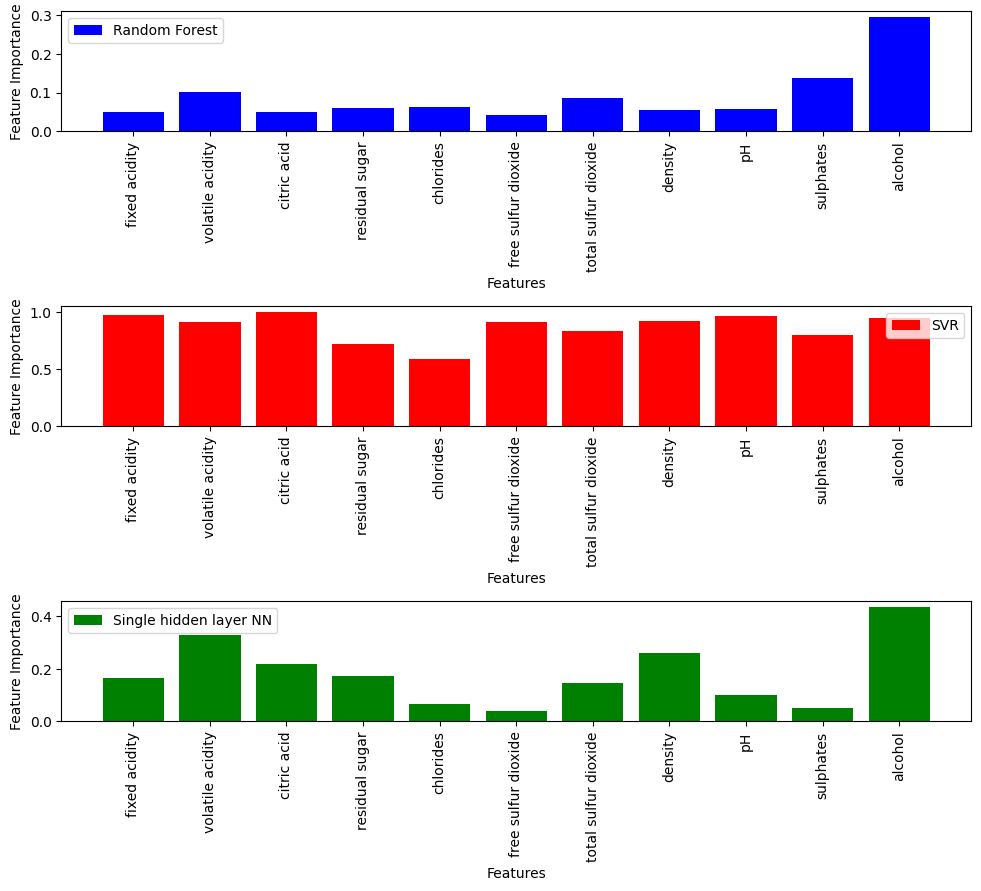

In [38]:
## Feature importance scores for rf
##ref : given above
importances = rfRed.feature_importances_ ##extract feature importance score of model

##svr
##we consider support vectors coefficient as measure of importance
#ref chat gpt define a function to get support vector coefficients
def SVR_feature_importance(data,svr_model): ##modified function inputs as per need
    # Get indices of support vectors
    support_vector_indices = svr_model.support_
    # Get dual coefficients (weights) for support vectors
    dual_coefficients = np.abs(svr_model.dual_coef_.flatten()) ##as two hyperparams
    # Calculate feature importance based on dual coefficients
    feature_importance = np.zeros(data.X_train_scaled.shape[1]) ##initialized empty array
    for sv_index, dual_coef in zip(support_vector_indices, dual_coefficients): ##iterate over indices and coefficients
        if sv_index < len(svr_model.support_vectors_):
            feature_importance += np.abs(svr_model.support_vectors_[sv_index] * dual_coef)##notion of feature imprtance as support vectors determine decesion boundary
    ##feuture importance list containing support vectors * weights
    # Normalize feature importance scores to range [0, 1]
    feature_importance_normalized = feature_importance / np.max(feature_importance)
    
    return feature_importance_normalized
##svr
svr_importance = SVR_feature_importance(Red,svrRed)

##nn
## we use permutation method ref given above
##basically we randomly shuffle value of each feature and observe degradation in model
result = permutation_importance(nn_modelRed, Red.X_train_scaled, Red.y_train, n_repeats=10, random_state=42)## 10 iterations
# Get feature importance scores
nn_importance = result.importances_mean

# PLOT RESULTTS
plt.figure(figsize=(10, 9))  
##RF
plt.subplot(3, 1, 1)
plt.bar(Red.features.columns, importances, label='Random Forest', color='blue')
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.xticks(rotation=90)
plt.legend()

# SVR
plt.subplot(3, 1, 2)
plt.bar(Red.features.columns, svr_importance, label='SVR', color='red')
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.xticks(rotation=90)
plt.legend()

# Neural Network
plt.subplot(3, 1, 3)
plt.bar(Red.features.columns, nn_importance, label='Single hidden layer NN', color='green')
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

Note : each feature importance score has been computed in a different method and convey different meaning in an absolute sense, the idea is to get a relative comparitive analysis of feuture importance accross models, Absolute scores given by different models shouldn't be compared

Comment : clearly different features share fdifferent importance depending on the learning method used by model , this is because of different model complexities (rf = non linear can capture non linear variations in features more easily than SVR)
also models may be more sensitive to specific representations of the data(feature engineering)

In [39]:
## Q1 D

## first approach error comparition for accuracy assessment
##test final model for red on white
PredictionRed = BestModelRed.predict(White.X_test_scaled)##predict
MSERedOnWhite = mean_squared_error(White.y_test,PredictionRed)##compute error
## whites model on red
PredictionWhite = BestModelWhite.predict(Red.X_test_scaled)
MSEWhiteOnRed = mean_squared_error(Red.y_test,PredictionWhite)
print(f"error when used Reds model on white : {MSERedOnWhite} as compared to {MSE_bestRed} for red on red\nerror when used Whites model on red : {MSEWhiteOnRed} as compared to {MSE_bestWhite} for whitw on white")


error when used Reds model on white : 0.5387609070294784 as compared to 0.3263209722222223 for red on red
error when used Whites model on red : 0.5117581018518519 as compared to 0.5387609070294784 for whitw on white


MSE suggest that we can use Whites model on red dataset but not vice versa becuase of less magnitude of error in cross data verification conducted above



Q2 Preliminary interpretation: the data is idle to test models for classification problem
various variables/features correspond to genetic makeup of mice and ultimately based on genotype/behaviour and treatement we have to assign them a particular class

multiple voids(null points) detected data has to be preprocessed accordingly

Assumption: 4 target classes namely genotype, behaviour treatment and class, question only asks us to predict genotype so that will be my target variable

In [33]:
## we can directly utilize our process data class for this part
##changes prertaining to classification problem

# Load the dataset
mice_data = pd.read_excel("Data_Cortex_Nuclear.xlsx")

##explore and visulaize data
##ref chat gpt ##null counter ,is_null converts every datapoint to bool (Non empty => 0 empty => non zero)
NullCountMice = mice_data.isnull().sum() ##sum all non zero gives null count in every column
##desriptive stats assosciated with data ref : https://www.w3schools.com/python/pandas/ref_df_describe.asp 
Des_Mice = mice_data.describe() ##obj connecting description (mean , median mode, max etc of data)
## create instance of class ProcessData
Mice = ProcessedData(mice_data,"Genotype")
N = Mice.N
D = Mice.D - 3 - 1 ##excluding mouse id and last three targers
print(f"""The given data has {N} samples\n  
{D}  no. of features\n
{NullCountMice} no. of null points in each feature and target set\n
description as follow {Des_Mice}""")

##preprocess
##fill null points
Mice.impute_data() ##used iterative imputer method of scikit learn as per given reference
##models every feature with missing value as function of othr features
##split 
Mice.trainTestSplit()
#standardise
Mice.standardize()

The given data has 1080 samples
  
77  no. of features

MouseID      0
DYRK1A_N     3
ITSN1_N      3
BDNF_N       3
NR1_N        3
            ..
CaNA_N       0
Genotype     0
Treatment    0
Behavior     0
class        0
Length: 82, dtype: int64 no. of null points in each feature and target set

description as follow           DYRK1A_N      ITSN1_N       BDNF_N        NR1_N       NR2A_N  \
count  1077.000000  1077.000000  1077.000000  1077.000000  1077.000000   
mean      0.425810     0.617102     0.319088     2.297269     3.843934   
std       0.249362     0.251640     0.049383     0.347293     0.933100   
min       0.145327     0.245359     0.115181     1.330831     1.737540   
25%       0.288121     0.473361     0.287444     2.057411     3.155678   
50%       0.366378     0.565782     0.316564     2.296546     3.760855   
75%       0.487711     0.698032     0.348197     2.528481     4.440011   
max       2.516367     2.602662     0.497160     3.757641     8.482553   

            pA

/home/prachit/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [47]:
## Q 2 c 
## we have imputed data set which has been duely splitted and standardise

##can be easily done using our class model with following changes
## random forest = use RandomForestClassifier
##SVM = SVC for classification
## nn = use sigmoid activation function instead  

##I made these changes in original class by defining a class variable is_regression

##also instead of mse  I used accuracy score : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
##train the three models
ModelMice = model(Mice,"classification") ##instance of model class with different data

# Validate Random Forest model
rfMice = ModelMice.randomForest()
RfpredictionsMice = rfMice.predict(Mice.X_val_scaled) ##model predictions on validation data
rf_accuracy_Mice = accuracy_score(Mice.y_val, RfpredictionsMice) ##compute mean square error\
print("Random Forest Validation accuracy score:",rf_accuracy_Mice) #normalized by default

## Validate SVR model
svrMice = ModelMice.SVR() ##created model
svr_predictionsMice = svrMice.predict(Mice.X_val_scaled) ##made predictions
svr_accuracy_mice = accuracy_score(Mice.y_val, svr_predictionsMice)##calculated error
print("SVR Validation accuracy score:", svr_accuracy_mice)

# Validate Neural Network model
nn_modelMice = ModelMice.NN() ##initialized model
nn_predictionsMice = nn_modelMice.predict(Mice.X_val_scaled) ##predict
nn_accuracy_mice = accuracy_score(Mice.y_val, nn_predictionsMice)## cal error
print("Neural Network Validation accuracy score:", nn_accuracy_mice)

Random Forest Validation accuracy score: 1.0
SVR Validation accuracy score: 0.9691358024691358


/tmp/ipykernel_37269/1006684136.py:61: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=self.CreateNeuralNetwork, epochs=50, batch_size=32, verbose=0)


6/6 [==============================] - 0s 1ms/step
Neural Network Validation accuracy score: 0.4567901234567901


In [52]:
## test best fit model against neural network as before
###select best model for red and white data set respectively
##make a dictionary to store errors of various models
accuracyMice = {rfMice: rf_accuracy_Mice, svrMice: svr_accuracy_mice,nn_modelMice: nn_accuracy_mice}## model -> mse
##best model has max accuracy
BestModelMice = max(accuracyMice,key=accuracyMice.get) ##best model name for red dataset
##test the models for sense of completion test our best model against NN (clearly not best)
PredictionBestModelMice = BestModelMice.predict(Mice.X_test_scaled)##predict
PredictionNNClass = nn_modelMice.predict(Mice.X_test_scaled)
Accuracy_bestMice = accuracy_score(Mice.y_test,PredictionBestModelMice)##compute error
Accuracy_nn = accuracy_score(Mice.y_test,PredictionNNClass)

print(f"Our best validated model {BestModelMice}, gives an accuracy of {Accuracy_bestMice} against NN which\naccuracy of only {Accuracy_nn}")

6/6 [==============================] - 0s 1ms/step
Our best validated model RandomForestClassifier(n_estimators=300, random_state=42), gives an accuracy of 0.9938271604938271 against NN which
acuracy of only 0.41975308641975306


Rfecv : recurrsively removes features and then fit model on remaining features. It ranks importance of each feature based on impact on model performance. Here model performance is evaluated using cross verification. In 5 fold cross verification model is trained on first 4 subsets and validated on remaining 5 , this is iterated over all 5 subsets
Removing least important features may infact improve overall performance of model

ref : = https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html



In [60]:
def do_RFECV(modeltype,X,y): ##object model
    selector = RFECV(modeltype,  step=1, cv=5)  # 5-fold cross-validation
    selector = selector.fit(X, y)
    OptNumber = selector.n_features_
    
    # Plot number of features vs. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
    plt.show()

    # store final optimal selected features
    ## feature selected if selection status stored in list (selector.support_) true
    selected_features = [feature for feature, s in zip(X.columns, selector.support_) if s]
    print("Selected features:", selected_features)
    
    return selected_features

# Perform RFECV for each model
X = ModelMice.X_train_scaled
y = ModelMice.y_train
##rf
selected_features_rf = do_RFECV(rfMice, X, y)
##svc
selected_features_svr = do_RFECV(svr_model, X, y)
##nn
selected_features_nn = do_RFECV(nn_model, X, y)


TypeError: RFECV() got an unexpected keyword argument 'step'

In [ ]:
##